We will model price for all categories. Our estimate of the parameter of product price can be considered a prediction.

In [12]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pystan
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing

plt.style.use('bmh')

In [13]:
df = pd.read_csv('train.tsv', sep = '\t')
df = df.sample(frac=0.01, random_state=99)
df = df[pd.notnull(df['category_name'])]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14760 entries, 800927 to 20724
Data columns (total 8 columns):
train_id             14760 non-null int64
name                 14760 non-null object
item_condition_id    14760 non-null int64
category_name        14760 non-null object
brand_name           8534 non-null object
price                14760 non-null float64
shipping             14760 non-null int64
item_description     14760 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 1.0+ MB


In [15]:
df.category_name.nunique()

689

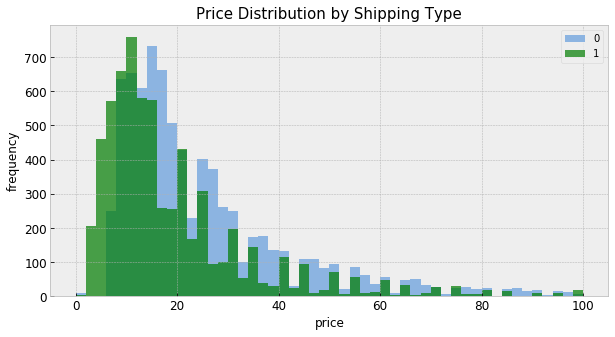

In [16]:
shipping_0 = df.loc[df['shipping'] == 0, 'price']
shipping_1 = df.loc[df['shipping'] == 1, 'price']
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(shipping_0, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label=0)
ax.hist(shipping_1, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label=1)
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show();

In [17]:
df.category_name.value_counts()[20:]

Home/Home Décor/Home Décor Accents                                 151
Women/Jeans/Slim, Skinny                                           150
Women/Jewelry/Bracelets                                            150
Women/Swimwear/Two-Piece                                           143
Men/Shoes/Athletic                                                 141
Women/Shoes/Sandals                                                139
Women/Women's Handbags/Shoulder Bag                                139
Kids/Toys/Dolls & Accessories                                      130
Women/Jewelry/Earrings                                             119
Women/Women's Accessories/Wallets                                  119
Kids/Toys/Action Figures & Statues                                 118
Women/Shoes/Athletic                                               114
Women/Women's Handbags/Totes & Shoppers                            112
Women/Sweaters/Hooded                                              103
Home/K

In [5]:
# df = df[(df.category_name == 'Women/Athletic Apparel/Pants, Tights, Leggings') | (df.category_name == 'Women/Tops & Blouses/T-Shirts') | (df.category_name == 'Beauty/Makeup/Face') | (df.category_name == 'Beauty/Makeup/Lips') | (df.category_name == 'Electronics/Video Games & Consoles/Games') | (df.category_name == 'Electronics/Cell Phones & Accessories/Cases, Covers & Skins') | (df.category_name == 'Beauty/Makeup/Eyes') | (df.category_name == 'Beauty/Fragrance/Women') | (df.category_name == 'Women/Dresses/Above Knee, Mini') | (df.category_name == 'Women/Underwear/Bras')]

"shipping == 0" means shipping fee paid by buyer, and "shipping == 1" means shipping fee paid by seller. In general, price is higher when buyer pays shipping.

In [18]:
df.groupby(['category_name', 'shipping'])['price'].mean()

category_name                                 shipping
Beauty/Bath & Body/Bath                       0            20.162162
                                              1            10.791667
Beauty/Bath & Body/Bathing Accessories        0            14.000000
                                              1            21.000000
Beauty/Bath & Body/Cleansers                  0            20.200000
                                              1            14.500000
Beauty/Bath & Body/Scrubs & Body Treatments   0            15.250000
                                              1            25.666667
Beauty/Bath & Body/Sets                       0            21.500000
                                              1            11.000000
Beauty/Fragrance/Candles & Home Scents        0            25.500000
                                              1            16.727273
Beauty/Fragrance/Kids                         0             7.000000
                                              1 

For construction of a Stan model, it is convenient to have the relevant variables as local copies - this aids readability.

* category: index code for each category name
* price: price
* category_names: unique category names
* categories: number of categories
* log_price: log price
* shipping: who pays shipping
* category_lookup: index categories with a lookup dictionary 

In [61]:
le = preprocessing.LabelEncoder()
df['category_code'] = le.fit_transform(df['category_name'])
category_names = df.category_name.unique()
categories = len(category_names)
category = df['category_code'].values
price = df.price
df['log_price'] = log_price = np.log(price + 0.1).values
shipping = df.shipping.values
category_lookup = dict(zip(category_names, range(len(category_names))))

We can explore the distribution of price (log scale) in the data.

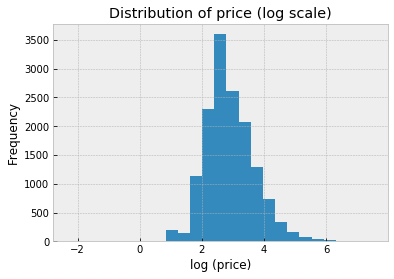

In [20]:
df.price.apply(lambda x: np.log(x+0.1)).hist(bins=25)
plt.title('Distribution of price (log scale)')
plt.xlabel('log (price)')
plt.ylabel('Frequency');

## Conventional approaches

There are two conventional approaches to modeling price represent the two extremes of the bias-variance tradeoff:

#### Complete pooling:

Treat all categories the same, and estimate a single price level.

$$y_i = \alpha + \beta x_i + \epsilon_i$$

* $y_i$: measured log(price) in product $i$
* $\alpha$: Original price across all products in the data
* $\beta$: effect on measured log(price) in moving from buyer pays shipping to seller pays shipping
* $\epsilon_i$: error in the model prediction for product %i%


The errors $\epsilon_i$ may represent measurement error, temporal within-category variation, or variation among categories.

To specify this model in Stan, we begin by constructing the data block, which includes vectors of log-price measurements (y) and who pays shipping covariates (x), as well as the number of samples (N).

### The complete pooling model

In [21]:
pooled_data = """
data {
  int<lower=0> N; 
  vector[N] x;
  vector[N] y;
}
"""
pooled_parameters = """
parameters {
  vector[2] beta;
  real<lower=0> sigma;
} 
"""
pooled_model = """
model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}
"""

When passing the code, data, and parameters to the stan function, we specify sampling 2 chains of length 1000.

In [22]:
pooled_data_dict = {'N': len(log_price),
                    'x': shipping,
                    'y': log_price}

sm = pystan.StanModel(model_code=pooled_data + pooled_parameters + pooled_model) 
pooled_fit = sm.sampling(data=pooled_data_dict, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd6a876b770652d53bdcc0546345af4b NOW.


Once the fit has been run, the method extract and specifying permuted=True extracts samples into a dictionary of arrays so that  we can conduct visualization and summarization.

We are interested in the mean values of these estimates for parameters from the sample. 

* b0 = alpha = mean common price across category
* m0 = beta = mean variation in price with change in who pays shipping

In [23]:
pooled_sample = pooled_fit.extract(permuted=True)
b0, m0 = pooled_sample['beta'].T.mean(1)
# The fitted parameters
print("alpha: {0}, beta: {1}".format(b0, m0))

alpha: 3.073095014121504, beta: -0.3673089564287129


We visualize how well this pooled model fits the observed data.

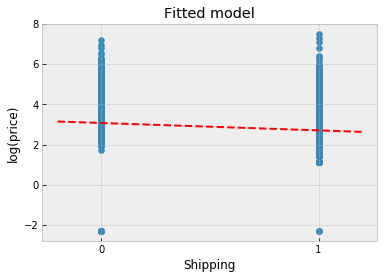

In [24]:
plt.scatter(df.shipping, np.log(df.price+0.1))
xvals = np.linspace(-0.2, 1.2)
plt.xticks([0, 1])
plt.plot(xvals, m0*xvals+b0, 'r--')
plt.title("Fitted model")
plt.xlabel("Shipping")
plt.ylabel("log(price)");

The fitted line runs through the centre of the data, and it describes the trend. However, the observed points vary widely about the fitted model, and there are multiple outliers indicating that the original price varies quite widely, and we might expect different gradients if we chose different subsets of the data.

### The unpooled model

When unpooling, we model price in each category independently. The equation:

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$
where $j = 1,\ldots,689$

* $y_i$: measured log(price) in product $i$
* $\alpha_{j[i]}$: original price in category $j[i]$, which is the category $j$ to which product $i$ belongs to
* $\beta$: effect on measured log(price) in moving from buyer pays shipping to seller pays shipping
* $\epsilon_i$: error in the model prediction for product %i%

The errors $\epsilon_i$ may represent measurement error, temporal within-product variation, or variation among products.

In [25]:
unpooled_model = """data {
  int<lower=0> N; 
  int<lower=1,upper=689> category[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[689] a;
  real beta;
  real<lower=0,upper=100> sigma;
} 
transformed parameters {
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- beta * x[i] + a[category[i]];
}
model {
  y ~ normal(y_hat, sigma);
}"""

When running the unpooled model in Stan, We again map Python variables to those used in the Stan model, then pass the data, parameters (transformed and untransformed) and the model to Stan. We again specify 1000 iterations of 2 chains.

In [26]:
unpooled_data = {'N': len(log_price),
                 'category': category+1, # Stan counts starting at 1
                 'x': shipping,
                 'y': log_price}

sm = pystan.StanModel(model_code=unpooled_model) 
unpooled_fit = sm.sampling(data=unpooled_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f36d1eee36587b9a63b136009337176 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Inspecting the fit

We can extract the sample from the fit for visualisation and summarisation. This time we do not use the permuted=True option. This returns a StanFit4Model object, from which we can extract the fitted estimates for a parameter using indexing, like a dictionary, e.g. unpooled_fit['beta'], and this will return a numpy ndarray of values. For  𝛼  (a) we get a 1000x689 array, for  𝛽  (beta) we get a 1000x1 array. Mean and standard deviation (and other summary statistics) can be calculated from these.

In [27]:
unpooled_estimates = pd.Series(unpooled_fit['a'].mean(0), index=category_names)
unpooled_se = pd.Series(unpooled_fit['a'].std(0), index=category_names)

To inspect the variation in predicted price at category resolution, we can plot the mean of each estimate with its associated standard error. To structure this visually, we'll reorder the categories such that we plot categories from lowest to highest.

In [28]:
unpooled_estimates.sort_values(ascending=False)[:10]

Beauty/Makeup/Body                                5.189951
Women/Athletic Apparel/Shorts                     4.811829
Beauty/Fragrance/Candles & Home Scents            4.749841
Women/Athletic Apparel/Tracksuits & Sweats        4.725700
Home/Bedding/Quilts                               4.694977
Handmade/Children/Art                             4.613045
Women/Tops & Blouses/Halter                       4.582723
Beauty/Tools & Accessories/Bags & Cases           4.556083
Kids/Girls 0-24 Mos/Swimwear                      4.534995
Vintage & Collectibles/Trading Cards/Animation    4.482391
dtype: float64

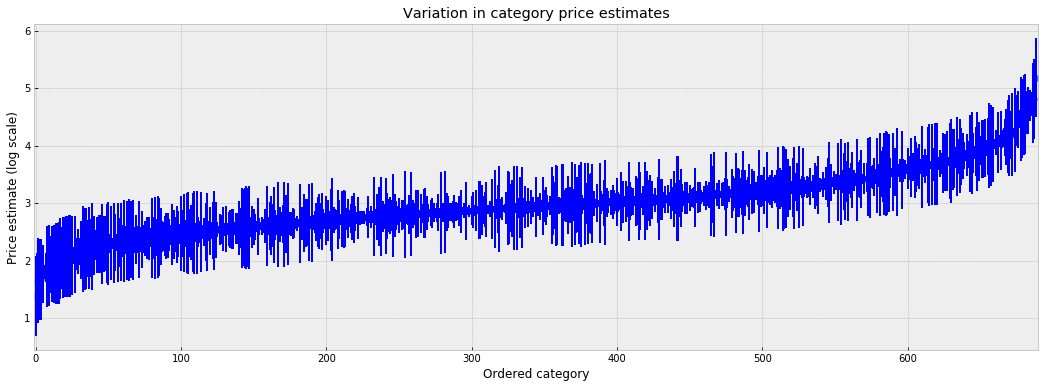

In [29]:
order = unpooled_estimates.sort_values().index

plt.figure(figsize=(18, 6))
plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-') 
    plt.xlim(-1,690); 
plt.ylabel('Price estimate (log scale)');plt.xlabel('Ordered category');plt.title('Variation in category price estimates');

From the above visualization, we can see that there are multiple categories with relatively low predicted price levels, and multiple categories with a relatively high predicted price levels. Their distance can be large. A single all-category estimate of all price level could not represent this variation well, and this confirms our suspicion that a pooled estimate is likely to have significant bias.

### Comparison of pooled and unpooled estimates

We can make direct visual comparisons between pooled and unpooled estimates for all categories, but we are going to show several examples, and I purposely select some categories with many products, and other categories with few products.

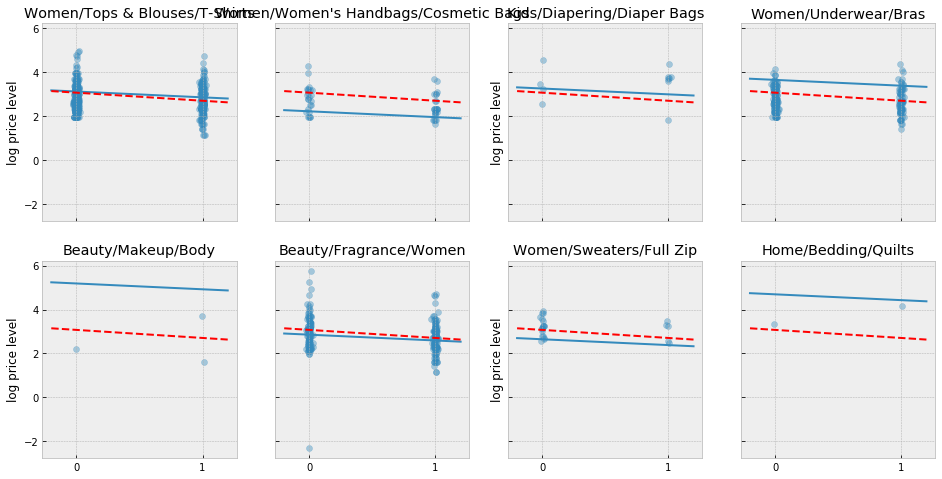

In [30]:
# Define subset of categories
sample_categories = ('Women/Tops & Blouses/T-Shirts', "Women/Women's Handbags/Cosmetic Bags", 
                   'Kids/Diapering/Diaper Bags', 'Women/Underwear/Bras', 'Beauty/Makeup/Body', 
                   'Beauty/Fragrance/Women', 'Women/Sweaters/Full Zip', 'Home/Bedding/Quilts')

fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_fit['beta'].mean(0)
for i,c in enumerate(sample_categories):
    y = df.log_price[df.category_name==c]
    x = df.shipping[df.category_name==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_estimates[c]
    
    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)  #unpooled
    axes[i].plot(xvals, m0*xvals+b0, 'r--')  # pooled
    axes[i].set_xticks([0,1])
#    axes[i].set_xticklabels(['buyer pays shipping', 'seller pays shipping'])
#    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log price level');

Let me try to explain what the above visualizations tell us: 

* The pooled models (red dashed line) in every category are the same, meaning all categories are modeled the same, indicating pooling is useless.
* For categories with few observations, the fitted estimates track the observations very closely, suggesting that there has been overfitting. So that we can't trust the estimates produced by models using few observations.

## Partial Pooling - simplest

The simplest possible partial pooling model for the retail price dataset is one that simply estimates prices, with no other predictors (i.e. ignoring the effect of shipping). This is a compromise between pooled (mean of all categories) and unpooled (category-level means), and approximates a weighted average (by sample size) of unpooled category estimates, and the pooled estimates, with the equation: 

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

* $\hat{\alpha}$ - partially-pooled estimate of price
* $n_j$ - number of samples in category $j$
* $\bar{y}_j$ - estimated mean for category $j$
* $\sigma_y^2$ - s.e. of $\bar{y}_j$, variability of the category mean
* $\bar{y}$ - pooled mean estimate for $\alpha$
* $\sigma_{\alpha}^2$ - s.e. of $\bar{y}$

In data:

* N will be the number of samples (int)
* category will be a list of N values from 1-689, specifying the category index each measurement
* y will be a vector of log(price) measurements, one per product/sample

We define parameters:

* a (vector, one value per category), representing $\alpha$, the vector of overall price for each category.
* mu_a, a real corresponding to $\mu_{alpha}$, the mean price underlying the distribution from which the category levels are drawn.
* sigma_a is $\sigma_{\alpha}$, the standard deviation of the price distribution underlying the category levels: variability of category means about the average.
* sigma_y is $\sigma_y$, the standard deviation of the measurement/sampling error: residual error of the observations.

In [31]:
partial_pooling = """
data {
  int<lower=0> N; 
  int<lower=1,upper=689> category[N];
  vector[N] y;
} 
parameters {
  vector[689] a;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] <- a[category[i]];
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal (10 * mu_a, sigma_a);

  y ~ normal(y_hat, sigma_y);
}"""

Now we have two standard deviations, one describing the residual error of the observations, and another describing the variability of the category means around the average.

In [32]:
partial_pool_data = {'N': len(log_price),
                     'category': category+1, # Stan counts starting at 1
                     'y': log_price}

sm = pystan.StanModel(model_code=partial_pooling)
partial_pool_fit = sm.sampling(data=partial_pool_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4387f6049b48554037b1a4c61e07bf78 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


We're interested primarily in the category-level estimates of price, so we obtain the sample estimates for a:

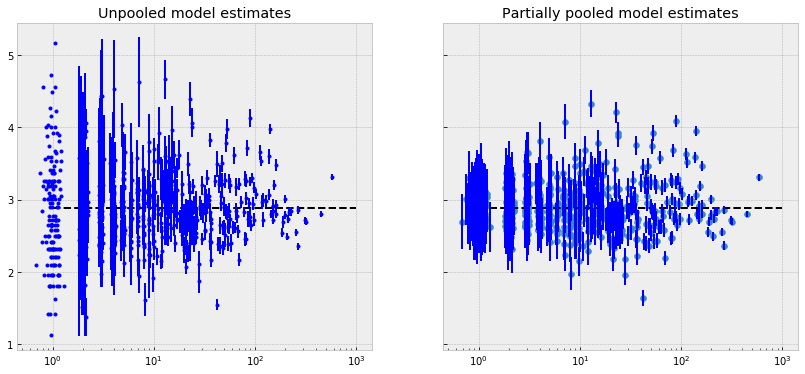

In [33]:
sample_trace = partial_pool_fit['a']

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
samples, categories = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=categories)

n_category = df.groupby('category_name')['train_id'].count()
unpooled_means = df.groupby('category_name')['log_price'].mean()
unpooled_sd = df.groupby('category_name')['log_price'].std()
unpooled = pd.DataFrame({'n':n_category, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 1, 1000, linestyles='--')

samples, categories = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_category.values + jitter, means)
axes[1].set_xscale('log')
# axes[1].set_xlim(100,1000)
# axes[1].set_ylim(2, 4)
axes[1].hlines(sample_trace.mean(), 1, 1000, linestyles='--')
for j,n,m,s in zip(jitter, n_category.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-');
    
axes[0].set_title("Unpooled model estimates")
axes[1].set_title("Partially pooled model estimates");

There are significant differences between unpooled and partially-pooled estimates of category-level price, The unpooled estimates look more extreme.

## Partial Pooling - Varying Intercept

This approach is similar to a least squares regression, but the multilevel modelling approach allows parameter distributions - information to be shared across categories, which can lead to more reasonable estimates of parameters with relatively little data. In this example, using a common distribution for the category-level price spreads the information about likely price levels such that our estimates for categories with few observations should be less extreme, with the equation: 

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

Simply put, the multilevel modeling shares strength among categories, allowing for more reasonable inference in categories with little data.

In data:

* J is the number of categories (int)
* N is the number of samples (int)
* category is a list of N values from 1-689, specifying the category index each measurement
* x is a vector of indices for which who pays shipping measurements were taken at each product
* y is a vector of log(price) measurements, one per product/sample.

Define parameters:

* a (vector, one value per category), representing $\alpha$, the vector of overall prices for each category.
* b (real) representing $\beta$, the effect of shipping choice
* mu_a, a real corresponding to $\mu_{\alpha}$, the mean price underlying the distribution from which the category levels are drawn.
* sigma_a is $\sigma_{\alpha}$, the standard deviation of the price distribution underlying the category levels: variability of category means about the average.
* sigma_y is $\sigma_y$, the standard deviation of the measurement/sampling error: residual error of the observations.

In [34]:
varying_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> category[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  real b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {

  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a[category[i]] + x[i] * b;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);

  b ~ normal (0, 1);
  
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [35]:
varying_intercept_data = {'N': len(log_price),
                          'J': len(n_category),
                          'category': category+1, # Stan counts starting at 1
                          'x': shipping,
                          'y': log_price}

sm = pystan.StanModel(model_code=varying_intercept)
varying_intercept_fit = sm.sampling(data=varying_intercept_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_689315579169ef722b737fd14cecd3fa NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


We can then collect the category-level estimates of the overall price, the intercept of the model, $\alpha_{j[i]}$, from a (1000 iterations x 689 categories):

There is no way to visualize all of these 689 categories together, so I'm visualize 20 of them.

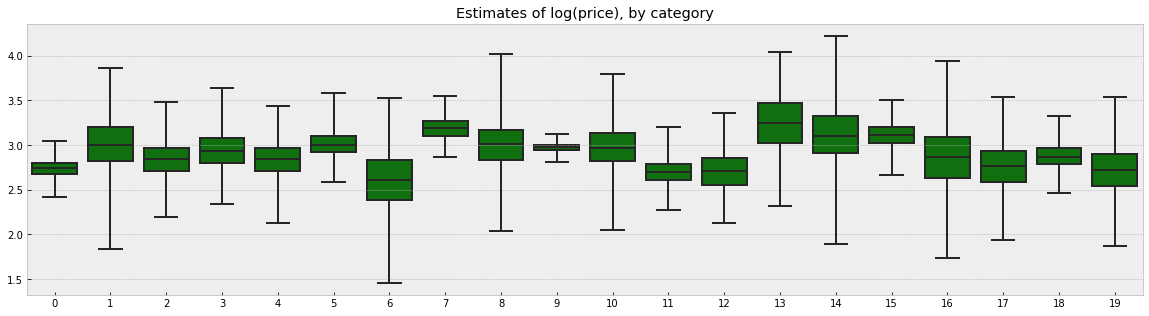

In [36]:
a_sample = pd.DataFrame(varying_intercept_fit['a'])
plt.figure(figsize=(20, 5))
g = sns.boxplot(data=a_sample.iloc[:,0:20], whis=np.inf, color="g")
# g.set_xticklabels(df.category_name.unique(), rotation=90)  # label counties
g.set_title("Estimates of log(price), by category")
g;

There's quite some variation in prices by category, and we can see that for example, category Beauty/Fragrance/Women (index at 9) with a large number of samples (225) also has one of the tightest range of estimated values. While category Beauty/Hair Care/Shampoo Plus Conditioner (index at 16) with the smallest number of sample (one only) also has the widest range of estimates.

We can visualize the distribution of parameter estimates for $\beta$ and $\sigma_{alpha}$:

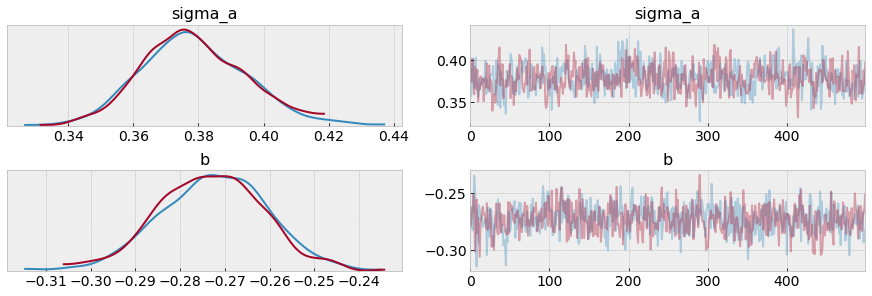

In [37]:
az.plot_trace(varying_intercept_fit, var_names = ['sigma_a', 'b']);

In [38]:
varying_intercept_fit['b'].mean()

-0.27304722263776227

The estimate for the shipping coefficient is approximately -0.27, which can be interpreted as products which shipping fee paid by seller at about 0.76 of ($\exp(-0.27) = 0.76$) the prices of those shipping paid by buyer, after accounting for category.

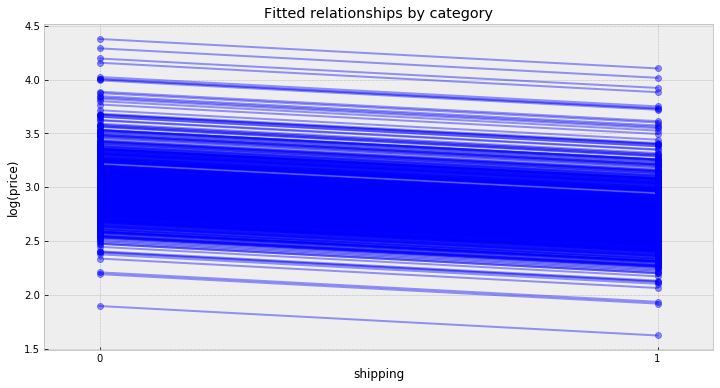

In [39]:
plt.figure(figsize=(12, 6))
xvals = np.arange(2)
bp = varying_intercept_fit['a'].mean(axis=0) # mean a (intercept) by category
mp = varying_intercept_fit['b'].mean()      # mean b (slope/shipping effect)
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1)
plt.xticks([0, 1])
plt.title('Fitted relationships by category')
plt.xlabel("shipping")
plt.ylabel("log(price)");

It is clear from this plot that we have fitted the same shipping effect to each category, but with a different price level in each category. There is one category with very low fitted price estimates, and several categories with relative lower fitted price estimates. Of course, there are multiple categories with relative higher fitted price estimates, but the bulk of categories form a majority set of similar fits.

We can see whether partial pooling of prevailing category-level price estimate has provided objectively more reasonable estimates than pooled or unpooled models, for categories with small sample sizes.

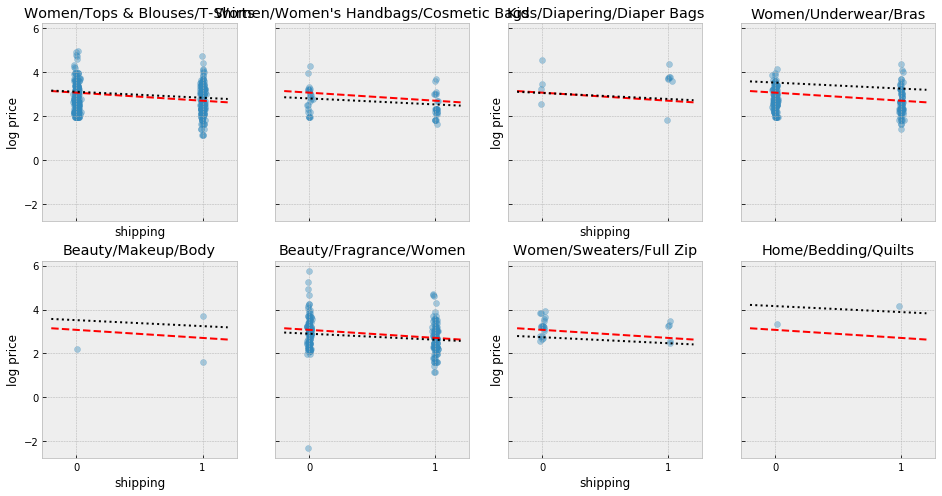

In [41]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sample_categories):
    
    # Plot county data
    y = df.log_price[df.category_name==c]
    x = df.shipping[df.category_name==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    m,b = unpooled_estimates[['shipping', c]]
    
    xvals = np.linspace(-0.2, 1.2)
    # Unpooled estimate
    axes[i].plot(xvals, m*xvals+b)
    # Pooled estimate
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    # Partial pooling esimate
    axes[i].plot(xvals, mp*xvals+bp[category_lookup[c]], 'k:')
    axes[i].set_xticks([0,1])
#    axes[i].set_xticklabels(['buyer pays shipping', 'seller pays shipping'])
#    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log price')
        axes[i].set_xlabel('shipping');

## Partial Pooling - Varying Slope model

We can also build a model that allows the categories to vary according to shipping arrangement (paid by buyer or paid by seller) influences the price. With the equation: 

$$y_i = \alpha + \beta_{j[i]} x_{i} + \epsilon_i$$

We can also extend partial pooling to a linear model of the relationship between measured log(price), the prevailing price level, and the effect of who pays shipping at which the measurement was made, where the category affects the effect of making the measurement at different shippings. In this linear model, the measured price level in a product $y_i$ is a function of the shipping at which measurement took place, $x_i$, with parameters $\alpha$ (the prevailing price level overall) and $\beta_{j[i]}$ (the influence of who pays shipping, which varies by category), and residual error $\epsilon_i$.

In data:

* J is the number of categories (int)
* N is the number of samples (int)
* category is a list of N values from 1-689, specifying the category index each measurement
* x is a vector of indices for who pays shipping the price measurements were taken at each product
* y is a vector of log(price) measurements, one per product/sample.

Define parameters:

* a (real) representing $\alpha$, the prevailing website-wide price level
* b (vector, one value per category), representing $\beta$, the vector of shipping effects for each category.
* mu_b, a real corresponding to $\mu_{\beta}$, the mean shipping effect underlying the distribution from which the category levels are drawn.
* sigma_b is $\sigma_{\beta}$, the standard deviation of the shipping effect distribution underlying the category level effects: variability of category means about the average.
* sigma_y is $\sigma_y$, the standard deviation of the measurement/sampling error: residual error of the observations

In [42]:
varying_slope = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> category[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  real a;
  vector[J] b;
  real mu_b;
  real<lower=0,upper=100> sigma_b;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {

  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a + x[i] * b[category[i]];
}
model {
  sigma_b ~ uniform(0, 100);
  b ~ normal (mu_b, sigma_b);

  a ~ normal (0, 1);

  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [43]:
varying_slope_data = {'N': len(log_price),
                      'J': len(n_category),
                      'category': category+1, # Stan counts starting at 1
                      'x': shipping,
                      'y': log_price}

sm = pystan.StanModel(model_code=varying_slope)
varying_slope_fit = sm.sampling(data=varying_slope_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e408fa35963c184d6b94760f4a12a6c4 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


We can then collect the category-level estimates of shipping effect, the slope of the model, $\beta_{j[i]}$, from b (1000 iterations x 689 categories):

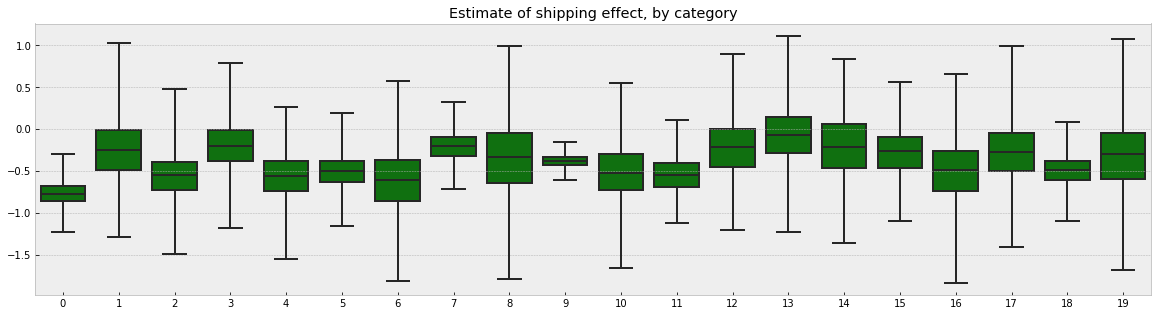

In [44]:
b_sample = pd.DataFrame(varying_slope_fit['b'])
plt.figure(figsize=(20, 5))
g = sns.boxplot(data=b_sample.iloc[:,0:20], whis=np.inf, color="g")
# g.set_xticklabels(df.category_name.unique(), rotation=90)  # label counties
g.set_title("Estimate of shipping effect, by category")
g;

From the first glance, you may not see any difference between these two boxplots. But if you look deeper, you will find that the variation in median estimates between categories in varying slope model becomes much smaller than those in varying intercept model, though the range of uncertainty is still greatest in the categories with fewest products, and least in the categories with the most products. 

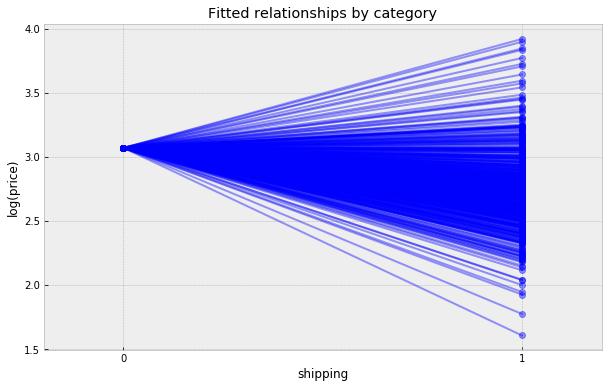

In [45]:
plt.figure(figsize=(10, 6))
xvals = np.arange(2)
b = varying_slope_fit['a'].mean()
m = varying_slope_fit['b'].mean(axis=0)
for mi in m:
    plt.plot(xvals, mi*xvals + b, 'bo-', alpha=0.4)
plt.xlim(-0.2, 1.2)
plt.xticks([0, 1])
plt.title("Fitted relationships by category")
plt.xlabel("shipping")
plt.ylabel("log(price)");

It is clear from this plot that we have fitted the same price level to each category, but with a different shipping effect in each category. There are two categories with very small shipping effects, but the majority bulk of categories form a majority set of similar fits.

## Partial Pooling - Varying Slope and Intercept

The most general way to extend partial pooling to this linear model is to allow both slope and intercept to vary by category. That is to model the relationship between measured log(price), the prevailing price level, and the effect of who pays shipping at which the measurement was made, where the category affects both the price level and the effect of making the measurement at different shipping.

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$

In this linear model, the measured price level in a product $y_i$ is a function of sho pays shipping at which measurement took place, $x_i$, with parameters $\alpha_{j[i]}$ (the prevailing price level in the category) and $\beta_{j[i]}$ (the influence of who pays shipping, which varies by category), and residual error $\epsilon_i$.

In data:

* J is the number of categories (int)
* N is the number of samples (int)
* category is a list of N values from 1-689, specifying the category index each measurement
* x is a vector of indices for which shipping the price measurements were taken at each product
* y is a vector of log(price) measurements, one per product/sample.

Define parameters:

* a (vector, one value per category), representing $\alpha$, the vector of prevailing price levels for each category.
* mu_a, a real corresponding to $\mu_{\alpha}$, the mean price level underlying the distribution from which the category levels are drawn.
* sigma_a is $\sigma_{\alpha}$, the standard deviation of the price level distribution underlying the category levels: variability of category means about the average.
* b (vector, one value per category), representing $\beta$, the vector of who pays shipping effects for each category.
* mu_b, a real corresponding to $\mu_{\beta}$, the mean shipping effect underlying the distribution from which the category levels are drawn.
* sigma_b is $\sigma_{\beta}$, the standard deviation of the shipping effect distribution underlying the category level effects: variability of category means about the average.
* sigma_y is $\sigma_y$, the standard deviation of the measurement/sampling error: residual error of the observations.

In [46]:
varying_intercept_slope = """
data {
  int<lower=0> N;
  int<lower=0> J;
  vector[N] y;
  vector[N] x;
  int category[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0> sigma_a;
  real<lower=0> sigma_b;
  vector[J] a;
  vector[J] b;
  real mu_a;
  real mu_b;
}

model {
  mu_a ~ normal(0, 100);
  mu_b ~ normal(0, 100);

  a ~ normal(mu_a, sigma_a);
  b ~ normal(mu_b, sigma_b);
  y ~ normal(a[category] + b[category].*x, sigma);
}
"""

In [47]:
varying_intercept_slope_data = {'N': len(log_price),
                                'J': len(n_category),
                                'category': category+1, # Stan counts starting at 1
                                'x': shipping,
                                'y': log_price}

sm = pystan.StanModel(model_code=varying_intercept_slope)
varying_intercept_slope_fit = sm.sampling(data=varying_intercept_slope_data, 
                                          iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eb106750305a375f12e2886d610f78d8 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


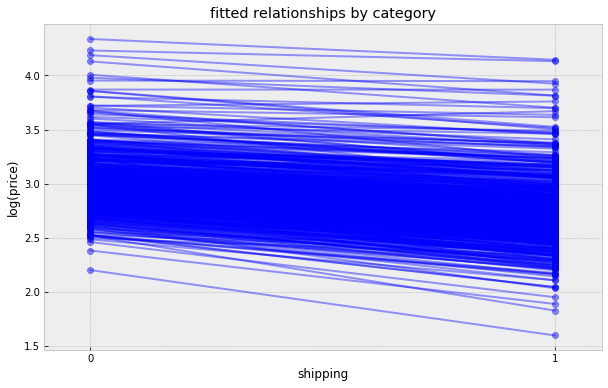

In [48]:
plt.figure(figsize=(10, 6))
xvals = np.arange(2)
b = varying_intercept_slope_fit['a'].mean(axis=0)
m = varying_intercept_slope_fit['b'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);
plt.xticks([0, 1])
plt.title("fitted relationships by category")
plt.xlabel("shipping")
plt.ylabel("log(price)");

While these relationships are all very similar we can see that by allowing shipping effect and price both to vary, we seem to be capturing more of the natural variation, compare with varying intercept model. 

## Contextual Effects

In some instances, having predictors at multiple levels can reveal correlation between individual-level variables and group residuals. We can account for this by including the average of the individual predictors as a covariate in the model for the group intercept.

In [52]:
# Create new variable for mean of shipping across categories
xbar = df.groupby('category_name')['shipping'].mean().rename(category_lookup).values
x_mean = xbar[category]

contextual_effect = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> category[N];
  vector[N] x;
  vector[N] x_mean;
  vector[N] y;
} 
parameters {
  vector[J] a;
  vector[3] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a[category[i]] + x[i]*b[2] + x_mean[i]*b[3];
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
"""

In [53]:
contextual_effect_data = {'N': len(log_price),
                          'J': len(n_category),
                          'category': category+1, # Stan counts starting at 1
                          'x_mean': x_mean,
                          'x': shipping,
                          'y': log_price}


sm = pystan.StanModel(model_code=contextual_effect)
contextual_effect_fit = sm.sampling(data=contextual_effect_data, 
                                         iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f9078af3c39f220d302816cbec25dfd1 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [54]:
contextual_effect_fit['b'].mean(0)

array([-0.03229224, -0.26463617, -0.29224872])

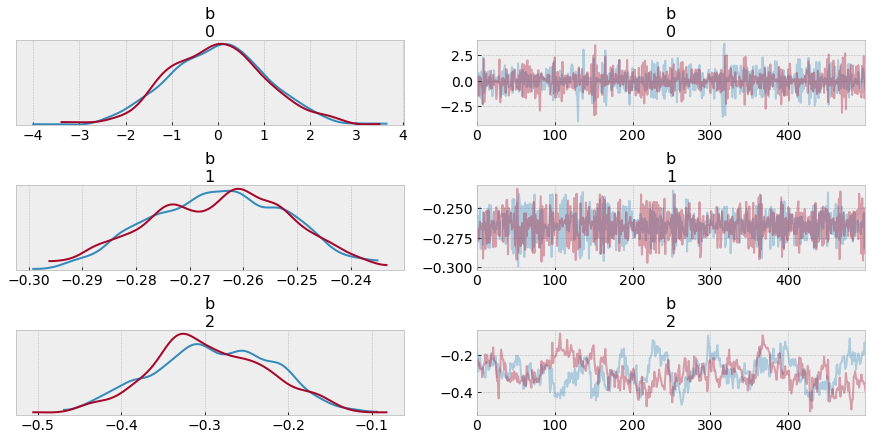

In [55]:
az.plot_trace(contextual_effect_fit, var_names = ['b']);

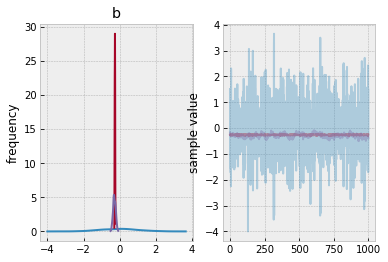

In [57]:
contextual_effect_fit.plot('b');

So, we might infer from this that categories with higher proportion of products shipping paid by seller have the similar  baseline levels of price with the categories with lower proportion of products.

### Prediction

In [63]:
category_lookup['Women/Athletic Apparel/Pants, Tights, Leggings']

13

In [64]:
contextual_pred = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=0,upper=J> wa;
  real xbar_wa;
  int<lower=1,upper=J> category[N];
  vector[N] x;
  vector[N] x_mean;
  vector[N] y;
} 
parameters {
  vector[J] a;
  vector[3] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  real wa_mu;

  for (i in 1:N)
    y_hat[i] <- a[category[i]] + x[i] * b[2] + x_mean[i] * b[3];
    
  wa_mu <- a[wa+1] + b[2] + xbar_wa * b[3];
 }
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
generated quantities {
  real y_wa;
  
  y_wa <- normal_rng(wa_mu, sigma_y);
}
"""

In [65]:
contextual_pred_data = {'N': len(log_price),
                        'J': len(n_category),
                        'category': category+1, 
                        'x_mean': x_mean,
                        'x': shipping,
                        'y': log_price,
                        'wa': 13,
                        'xbar_wa': xbar[13]}

sm = pystan.StanModel(model_code=contextual_pred)
contextual_pred_fit = sm.sampling(data=contextual_pred_data, 
                                         iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0f1a4680f2b6859ffdb66eb3e65d55ff NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


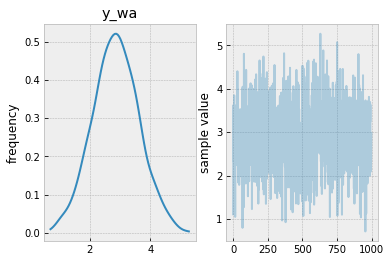

In [66]:
contextual_pred_fit.plot('y_wa');

In [67]:
df.loc[df['category_name'] == 'Women/Athletic Apparel/Pants, Tights, Leggings']['price'].describe()

count    585.000000
mean      33.430769
std       22.623688
min        4.000000
25%       18.000000
50%       27.000000
75%       44.000000
max      181.000000
Name: price, dtype: float64

The mean value sampled from this fit is ≈3, so we should expect the measured price in a new product in "Women/Athletic Apparel/Pants, Tights, Leggings" category, when shipping paid by seller, to be ≈exp(3) ≈ 20.09, though the range of predicted values is rather wide.